<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/ODR_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [ODE Based Models in Stan](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-margossian-gillespie-ode.html)

#### [Example: simple harmonic oscillator](https://mc-stan.org/docs/stan-users-guide/example-simple-harmonic-oscillator.html#example-simple-harmonic-oscillator)

## [Bayesian workflow for disease transmission modeling in Stan](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

#### [ Ordinary differential equation (ODE) solvers](https://mc-stan.org/docs/functions-reference/functions-ode-solver.html#functions-ode-solver)


In [1]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘Rcpp’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’




In [2]:
library(rstan)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [3]:
parallel::detectCores()

[1] 8

In [4]:
#example(stan_model, package = "rstan", run.dontrun = TRUE)

In [5]:
install.packages('tidybayes')

Installing package into ‘/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [6]:
knitr::opts_chunk$set(echo = TRUE)
# color palette
c_light <- c("#fee0d2")
c_mid <- c("#fc9272")
c_dark <- c("#de2d26")
c_simu <- "chartreuse3"
c_posterior = "orange"
c_prior = "aquamarine2"

set.seed(1) # for reproductibility



---



## COVID-19 transmission in Switzerland

#### To illustrate the ideas presented in this tutorial, we are going to tackle a more complex example: COVID-19 transmission in Switzerland during the period from February 2020 to June 2020. We’ll see that in this more complicated setting, sampling from the posterior distribution can be difficult, and we’ll need to rely on Stan’s diagnostics to check that our inference is reliable.

In [7]:
library(tidybayes)
library(tidyverse)
library(gridExtra)
df_swiss <- read_csv("./disease_transmission_workflow/data/swiss_agg_data.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 132 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): onset_dt, test_dt, report_dt, hospit_dt, death_dt, death_dt_hospit...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
spec(df_swiss)

cols(
  date = col_date(format = ""),
  onset_dt = col_double(),
  test_dt = col_double(),
  report_dt = col_double(),
  hospit_dt = col_double(),
  death_dt = col_double(),
  death_dt_hospit = col_double(),
  death_dt_nohospit = col_double(),
  total_tested = col_double()
)

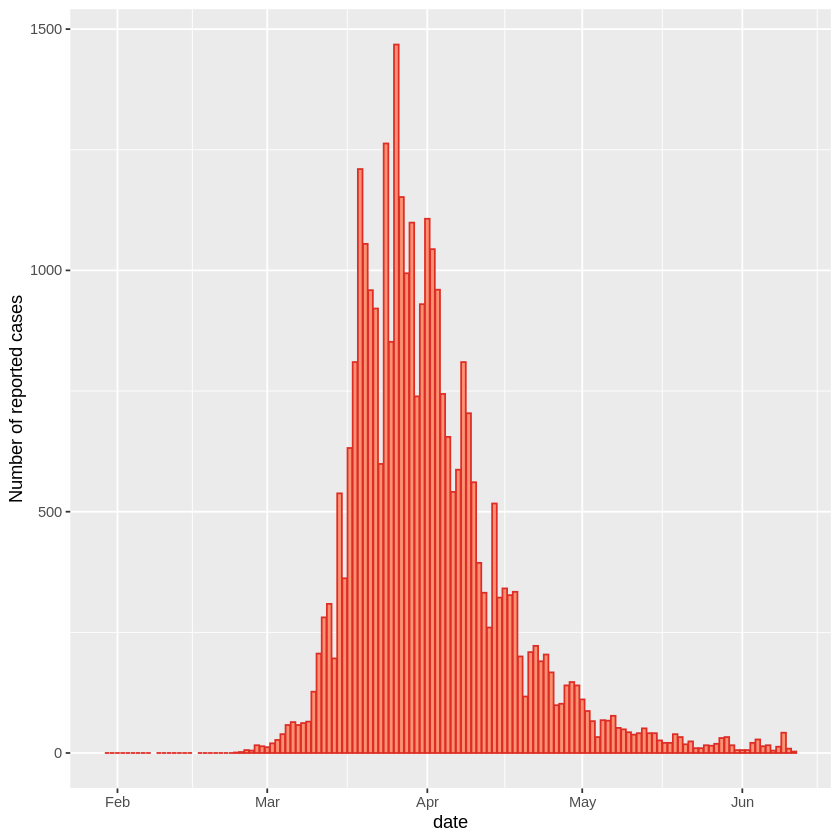

In [9]:
df_swiss %>% 
  ggplot() + 
  geom_bar(mapping = aes(x = date, y = report_dt), fill = c_mid, color = c_dark, stat = "identity") +
  labs(y="Number of reported cases")

### We are going to fit our basic model to the COVID-19 data, but we first need to make a few changes. In the influenza example, the number of students in bed was data on the disease prevalence, that is the number of students infected at time t. In this new setting, we only have access to the number of new cases on each given day, which constitutes incidence data. In a SIR model, the incidence of the disease at time t is the number of people leaving the Susceptible compartment at time t.

In [10]:
# Swiss population
N <- 8.57E6;

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

In [11]:
sir_model <- stan_model("./disease_transmission_workflow/stan_models/models_swiss/sir_ode_incidence.stan")

In [12]:
# Cases
cases <- df_swiss$report_dt

# times
n_days <- length(cases)
t <- seq(1, n_days, by = 1)
t0 = 0
t <- t

data_sir <- list(n_days = n_days, y0 = y0, t0 = t0, ts = t, N = N, cases = cases)

In [13]:
fit_sir <- sampling(sir_model, 
                    data_sir, 
                    iter=1000,
                    seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001252 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 12.52 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 91.326 seconds (Warm-up)
Chain 1:                107.553 seconds (Sampling)
Chain 1:                198.879 se

Warning message:
“There were 5 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.55, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.7801372,0.553466534,0.83484648,0.38591564,0.9782060,2.0614799,2.3558439,2.9320257,2.275257,2.895877
gamma,1.5531271,0.618196989,0.92248816,0.03706762,0.7152223,1.8852759,2.1886564,2.7720489,2.226731,3.155414
phi,0.2957008,0.001813447,0.02779067,0.24476672,0.2748894,0.2939718,0.3143666,0.3517951,234.848748,1.031910


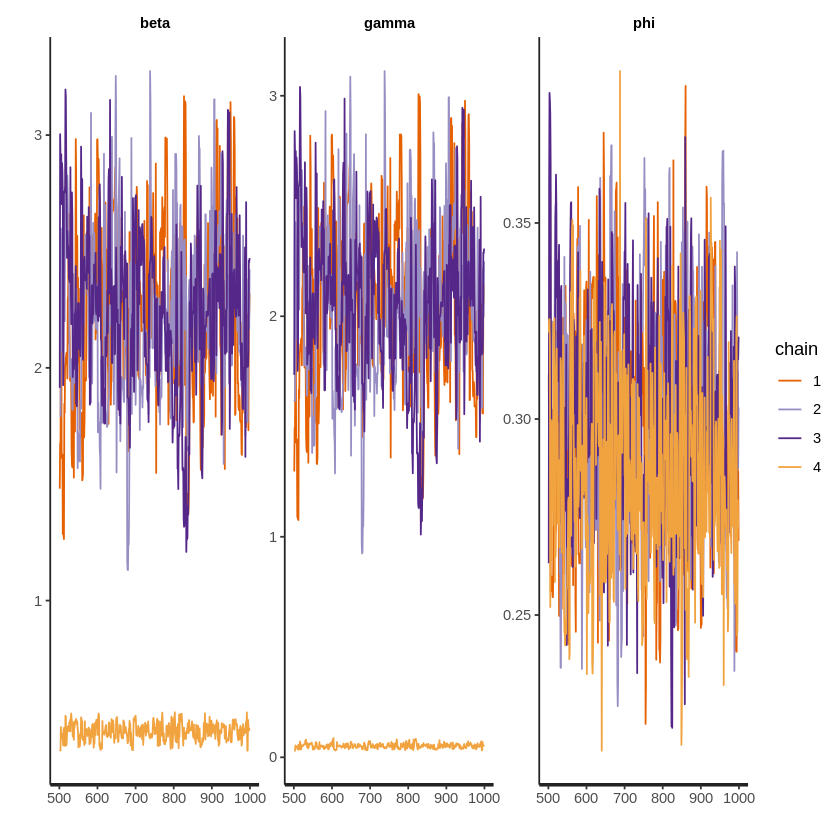

In [14]:
pars = c("beta", "gamma", "phi")
summary(fit_sir, pars=pars)
traceplot(fit_sir, pars=pars)

Joining with `by = join_by(n_days)`
`summarise()` has grouped output by 'n_days'. You can override using the
`.groups` argument.


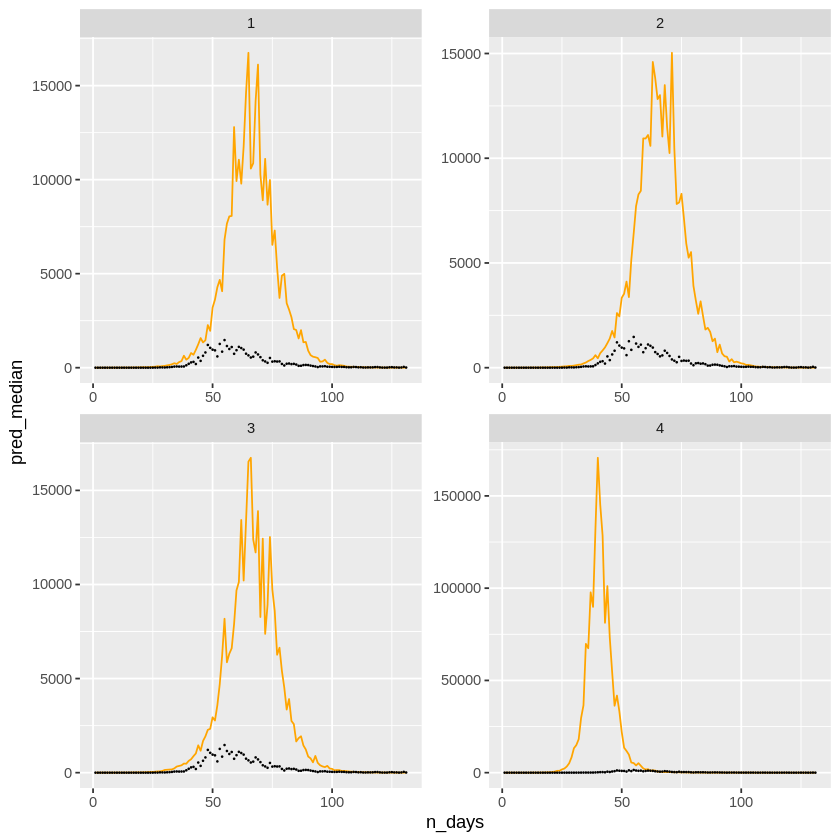

In [15]:
fit_sir %>% 
  spread_draws(pred_cases[n_days]) %>% 
  left_join(tibble(cases = cases, n_days = 1:length(cases))) %>% 
  group_by(n_days, .chain) %>% 
  summarise(cases = mean(cases), pred_median = median(pred_cases), pred_9 = quantile(pred_cases, 0.95), pred_1 = quantile(pred_cases, 0.05)) %>% 
   ggplot(aes(x = n_days)) +
   #geom_ribbon(aes(ymin = pred_1, ymax = pred_9), fill = c_mid, alpha=0.7)+
   geom_line(mapping = aes(y=pred_median), color = c_posterior)+
   geom_point(mapping = aes(y=cases), size=0.1)+
  facet_wrap(~.chain, scales = "free")